In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import requests
from spotipy.oauth2 import SpotifyOAuth
from tqdm import tqdm
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import time
from google.cloud import bigquery
import os

import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder

# Genre

In [127]:
import joblib
import pickle
gb = pickle.load(open('../../Model/gb_0.4343.sav','rb'))
#gb = joblib.load('../../Model/gb_0.4343.sav')

In [156]:
%%bigquery genre
SELECT distinct * FROM snappy-boulder-378707.NewReleases.NewAudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [157]:
dummy_cols = ['key','mode','time_signature']
genre= pd.get_dummies(genre, columns=dummy_cols)
genre.drop(['energy', 'loudness'],axis=1, inplace=True)

In [158]:
features = pd.read_csv("../../Model/Genre_classification_features.csv")

In [159]:
for col in set(features.iloc[:,0].values) - set(genre.iloc[:,1:].columns):
    genre[col] = 0
sc = MinMaxScaler(feature_range = (0,100))
genre_trans = sc.fit_transform(genre.iloc[:,1:])

In [160]:
pred_genre = gb.predict(genre_trans)

In [162]:
genre['Genre'] = pred_genre

In [164]:
genre = genre[['id','Genre']]

In [165]:
genre

,id,Genre
0,7rXQXbK4pQo8DSKlZ9ZSjC,K-Pop
1,2LRqm962By8aNwJX0WxFNG,Folk & Acoustic
2,0Oqxt6JixieLHbwMfnJGWO,Jazz
3,0tYtfBFJLVn2ITE66FbaLT,Indie
4,5ZSqX1dDJ823Dndw94nogY,Dance Electronic
...,...,...
179,1Oi8jp3BvmESVXIPtJ06a5,K-Pop
180,2lxwvwNTCT6T2k9agnujeO,Mandopop
181,6f6jhTzxwvAYhzZrABTO8T,Malay Pop
182,4Fx7GtXOK8k3rxVgKzi6ko,Mandopop


# Popularity

In [2]:
%%bigquery popularity
SELECT distinct s1.id,
s1.explicit,
s1.available_markets,
artist_id,
danceability,
energy,
key,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
duration_ms,
time_signature,
release_date FROM `snappy-boulder-378707.NewReleases.NewTracks`  as s1
inner join `snappy-boulder-378707.NewReleases.NewAudioFeatures`as s2
on s1.id = s2.id
inner join `snappy-boulder-378707.NewReleases.NewAlbums` as s3
on s1.album_id = s3.id

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
%%bigquery artist
SELECT distinct id, followers, popularity FROM `snappy-boulder-378707.TrackClearInfo.ArtistInfo`

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
popularity = popularity.assign(artist_id=popularity.artist_id.str.split(";")).explode('artist_id')

In [5]:
popularity = pd.merge(popularity, artist, left_on="artist_id",right_on="id", how="left")

In [6]:
popularity.columns = ['id_track', 'explicit', 'available_markets', 'artist_id', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_date', 'artist_id', 'followers', 'popularity_artist']
popularity.drop_duplicates(inplace=True)

In [7]:
popularity = popularity.groupby(['id_track', 'explicit', 'available_markets','danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'release_date'], as_index=False).aggregate({'followers':'mean','popularity_artist':'mean'})

In [8]:
import datetime as dt
popularity['release_date']=popularity['release_date'].map(dt.datetime.toordinal)
prediction = popularity[['id_track']]
result = popularity[['id_track']]
popularity.drop(['id_track'],axis=1, inplace=True)

In [11]:
import joblib
transformer = joblib.load(open('../../Model/Popularity Prediction Data Preprocess.sav','rb'))
popularity = transformer.transform(popularity)

In [13]:
import joblib
lr = joblib.load(open('../../Model/Popularity Prediction Model.sav','rb'))

In [16]:
pred_lr = lr.predict(popularity)
result['Popularity'] = pred_lr

<AxesSubplot: >

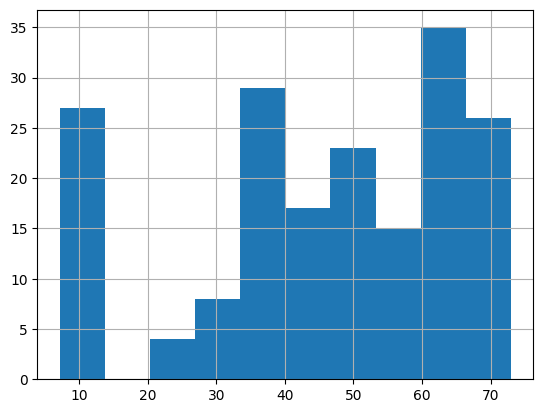

In [17]:
result['Popularity'].hist()